## *Background*

At the heart of the modern LLM boom is the transformer model architecture.
Fundamentally, transformers are tools designed to accurately predict the next word that will occur after any given sequence of prior words.
They accomplish this by converting tokens, a smaller unit of language than words, into high-dimensional vectors and then performing a series of matrix operations on them, the internal parameters of which are iteratively tweaked such that the last vector at the end of these operations corresponds to a ranked superposition of potential next tokens.


![3b1b_wordsasvec](https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2024/gpt/token.png)
Figure 1: Words represented as vectors in a transformer model. Credit to [3Blue1Brown](https://www.3blue1brown.com/lessons/gpt) for image.


These iterative operations are organized as layers.
Conceptually, each layer should tweak its internal weights so that it embeds additional information about what the predicted token should be into the sequence of vectors flowing through the transformer.
After passing through each layer, the vector for the predicted word should be iteratively transformed into a vector that will produce a high-quality token prediction.


![3b1b_layers](https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2024/gpt/arrays.png)
Figure 2: Sequences of vectors passing through layers of a transformer model. Credit to [3Blue1Brown](https://www.3blue1brown.com/lessons/gpt) for image.


[comment]: <> (this is a good point to include lit review)
Comparing the state of these internal vectors after each layer, i.e., at layer $l$ vs. $l+1$, may provide some insight on the information injected into the vectors by each layer.
In this work, I utilize a comparative technique to isolate distinct transformative paths of factual and hallucinated LLM outputs, with a goal of developing a monitoring technique to flag hallucinations before they are shown to a user.
A robust methodology to monitor hallucinated outputs would reduce the risk of unsafe misinformation dissemination and increase trustworthiness of LLMs.

## *Data & Methodology*

### Datasets
Assessing whether an LLM output is a hallucination is not a trivial task in most circumstances.
In order to guarantee that data are labelled accurately, I limit the scope of this project to simple math problems.
This work uses two datasets of addition problems: one comprised of outputs where the LLM correctly solves the problem and one where it does not.

All LLM inputs are of the form
```
The sum of {int1} and {int2} equals
```
The `int` variables range from $10^2$ to $10^7$.
Since transformers output one token at a time, and each token is a single digit number, the quantity of data points can be increased by generating them recursively.
For example, the input
```
The sum of 1 and 12 equals
```
will produce `1` first, leading to
```
The sum of 1 and 12 equals 1
```
which leads to `3` for the next token. Both of these outputs are a unique data point. If the prediction is correct, the data point is binned in the "Factual" dataset, and in the "Hallucination" dataset if not.
There is significant class imbalance between the two, with the Factual dataset containing 24637 records and the Hallucination dataset containing 363 records.
Each dataset is separated into training and testing splits with a test data fraction of 20%.

### Model
To remain within computational limitations, I used the Qwen3 4 billion parameter base model and its associated tokenizer.
Due to its small size, it is worth noting that hallucinations will be more common than flagship models, even for simple math.

### Tracing Transformative Paths
Cosine similarity is a popular measure of similarity between two vectors.
Two vectors pointing in the same direction will have a cosine similarity value of +1 or -1 if they point in the exact opposite directions.
A value of 0 indicates the two vectors point in direction orthogonal to each other.


![cosine_similarity](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.width-745.jpg)

Figure 3: The range of values possible for cosine similarity between two vectors. Credit to [LearnDataSci](https://www.learndatasci.com/glossary/cosine-similarity/) for image.


Of all the hidden vectors, the last one in the last hidden state is of particular importance:
It is the only vector that is ultimately converted back to a token.
As such, it is an obvious candidate for tracing similarity throughout layers.
For each data record, I compare the cosine similarity of the last vector of each hidden state to the last vector of the prior hidden state.
Aggregating cosine similarity values across each dataset produces trends common across all addition problems represented in the data.

### Kernel Density Estimation
Distributions of each dataset at each layer are smoothed using a density esimation routine with a Gaussian kernel.
The bandwidth parameter of the Gaussian kernel is chosen by searching for a value (search range: $10^{-2}$ to $10^{-1}$) that optimizes the log-likelihood of a fit.

### Classification Models
I test various classification methods: naive probability aggregation, support vector machines, random forest, and gradient boosted trees.
Each method has its own hyperparameters and I attempt to determine ideal combinations for each through  trial-and-error.


## *Results*

![distribution_comparison](temp.png)

Figure 4: Comparison of the distributions of Factual ("correct") and Hallucination ("incorrect") cosine similarities for an example layer.

Using the nonparametric Kolmogorov–Smirnov equality test to compare distributions at all monitored layers (e.g., Figure 4) reveals that the distributions are often statistically different.
Between 15 to 20 of the 34 total layers monitored reject the null hypothesis (p value < 0.05), depending on the exact training/testing data split.

With the exception of probability aggregation, all classification models perform at a comparable level.
See Appendix B for code, confusion matrices, and summary statistics.
Due to the severe class imbalance, metrics like recall and precision are more meaningful than overall accuracy (predicting all inputs as Factual gives an accuracy of ~98.5%, but will not catch any hallucinations).
Of the two metrics, models tend to perform stronger in the recall metric, hovering around 70-80%.
This indicates an automated monitoring routine that catches most hallucinations is feasible, but its trustworthiness is negatively impacted by the poor precision of these classification models (5-8%).

## *Discussion*

The statistically significant distinctions between distributions at various monitoring sites in a transformer (e.g., Figure 4) show that there is potential with this technique for identifying hallucinations before they are presented to a user.
If Factual/Hallucination datasets manifest as different distributions, the likelihood of a new point corresponding to either dataset may be quantifiable.

To make these results more usable in general, this work needs to be extended to natural language situations.
Building hallucination vs. factual datasets becomes more difficult in this case, since unlike math problems, which have a defined correct/incorrect answer, natural language is often more ambiguous.
A preliminary step could be to build datasets of completions that will have a definite correct answer.
For example, the completion
```
The capital city of France is
```
has a well-defined correct answer of `Paris`.
Generalizing beyond simple message templates is also needed.

Another necessary step in generalizing these results is to analyze transformative paths in different models.
This work uses a Qwen3 base model, which are not the LLMs consumers interact with on sites like ChatGPT.
Those have been fine tuned beyond their pretraining and so they may have weights that lead to different transformative paths than those seen in base models.
Consumer grade LLMs are also much larger than the 4 billion parameter model used here.
Both of these shortcomings are straightforward to address with additional computational resources.


## *Appendix A: Dataset creation and analysis*

In [ ]:
%%capture
!pip install -U transformers
!pip install --upgrade torch
!pip install kernels
!pip install torchinfo

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchinfo
import random

In [ ]:
import os
from google.colab import drive
drive.mount('drive')

In [ ]:
!ls "drive/MyDrive/AISES Course/Research Project"

In [ ]:
%%capture
model_id = "Qwen/Qwen3-4B-Base"

torch.no_grad()
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='cuda',
                                             torch_dtype='auto')
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
def get_next_token(hidden_states, model, tokenizer):
  target_tensor = hidden_states[-1].squeeze()[-1]
  target_logits = model.lm_head(target_tensor)
  return tokenizer.decode(target_logits.argmax(dim=-1))

def generate_cos_sims_for_token(message, model, tokenizer,
                                vector_pos=-1, comp='prev'):
  inputs = tokenizer(message, return_tensors="pt").to(model.device)
  generated = model(**inputs, max_new_tokens=1, output_hidden_states=True)
  predicted_token = get_next_token(generated.hidden_states, model, tokenizer)
  if vector_pos == 'all':
    # this functionality does not work as of rn
    cos_sims = []
    for row in range(generated.hidden_states[0].squeeze().shape[0]):
      cos_sims.append(torch.tensor(np.array(calc_sims(generated.hidden_states, vector_pos=row, comp=comp))))
    cos_sims = torch.stack(cos_sims)
  else:
    cos_sims = calc_sims(generated.hidden_states, vector_pos, comp)
  return predicted_token, cos_sims

def calc_sims(hidden_states, vector_pos=-1, comp='prev'):
  if comp == 'prev':
    prev_target_tensor = hidden_states[0].squeeze(0)[vector_pos]
  elif comp == 'first':
    # using 1 as the index below since that's the one after the first
    # transformer layer
    # 0 is right after vocab dim to embedding dim
    prev_target_tensor = hidden_states[1].squeeze(0)[vector_pos]
  elif comp == 'last':
    # -2 below because -1 corresponds to embeddings after RMSNorm i think
    # hard to tell for sure, but the differential cos_sim jumps a lot there
    prev_target_tensor = hidden_states[-2].squeeze(0)[vector_pos]
  sim_func = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
  cos_sims = []
  for hidden_state in hidden_states[1:]:
    target_tensor = hidden_state.squeeze(0)[vector_pos]
    cos_sim = sim_func(target_tensor, prev_target_tensor)
    cos_sims.append(cos_sim.cpu().detach().float().numpy())
    if comp == 'prev':
      prev_target_tensor = target_tensor
  # removing the first and last entries here because of the reasons outlined
  # in the IF statement in the beginning of this function
  return cos_sims[1:-1]

def standardize(x):
  return (x - x.mean()) / x.std()

def get_statistics(x, axis=0):
  # x is an np array
  return {'mean': np.mean(x, axis=axis),
          'median': np.median(x, axis=axis),
          'std': np.std(x, axis=axis, ddof=1),
          'min': np.min(x, axis=axis),
          'max': np.max(x, axis=axis),
          'p16': np.percentile(x, 16, axis=axis),
          'p84': np.percentile(x, 84, axis=axis),
          'shape': x.shape
          }

In [ ]:
def generate_num_dataset(num_samples, start_num, max_num, model, tokenizer):
  samples_done = 0
  correct_cos_sims = []
  incorrect_cos_sims = []
  while samples_done < num_samples:
    first_integer = random.randint(start_num, max_num)
    second_integer = random.randint(start_num, max_num)
    base_message = f'The sum of {first_integer} and {second_integer} equals '
    true_sum = first_integer + second_integer
    # maybe its better to just pick a random i
    for i in range(len(str(true_sum))):
      beginning_digits = str(true_sum)[:i]
      message = base_message + beginning_digits
      true_label = str(true_sum)[i]
      predicted_token, cos_sims = generate_cos_sims_for_token(message, model, tokenizer)
      if predicted_token == true_label:
        correct_cos_sims.append(cos_sims)
      else:
        incorrect_cos_sims.append(cos_sims)
      samples_done += 1
      if samples_done % 100 == 0:
        print(f'Samples done: {samples_done}/{num_samples}')
        print(f'Correct samples: {len(correct_cos_sims)}')
        print(f'Incorrect samples: {len(incorrect_cos_sims)}')
  return np.array(correct_cos_sims), np.array(incorrect_cos_sims)

In [ ]:
correct_data, incorrect_data = generate_num_dataset(25000, int(1e2), int(1e7),
                                                    model, tokenizer)

# import pickle
# with open('drive/MyDrive/AISES Course/Research Project/20250910_correct.pkl', 'wb') as f:
#   pickle.dump(correct_data, f)
# print('Saved correct data')
# with open('drive/MyDrive/AISES Course/Research Project/20250910_incorrect.pkl', 'wb') as f:
#   pickle.dump(incorrect_data, f)
# print('Saved incorrect data')
# from google.colab import runtime
# runtime.unassign()

In [ ]:
print(f'There are {correct_data['count']} correct predictions and {incorrect_data['count']} incorrect predictions.')

plt.errorbar(range(len(correct_data['median'])), correct_data['median'],
             yerr=np.array([correct_data['median'] - correct_data['16th'], correct_data['84th'] - correct_data['median']]),
             marker='o', label='correct', capsize=4)

plt.errorbar(range(len(incorrect_data['median'])), incorrect_data['median'],
             yerr=np.array([incorrect_data['median'] - incorrect_data['16th'], incorrect_data['84th'] - incorrect_data['median']]),
             marker='o', label='incorrect', capsize=4)

plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.title('Embedding at Layer t Relative to Layer t-1')
plt.show()

## *Appendix B: Classification tests*

In [1]:
from scipy.stats import gaussian_kde, ks_2samp
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random

In [ ]:
import os
from google.colab import drive
drive.mount('drive')

In [2]:
local_path_correct = '20250910_correct.pkl'
local_path_incorrect = '20250910_incorrect.pkl'

drive_path_correct = 'drive/MyDrive/AISES Course/Research Project/' + local_path_correct    
drive_path_incorrect = 'drive/MyDrive/AISES Course/Research Project/' + local_path_incorrect

correct_data = np.load(local_path_correct, allow_pickle=True)
incorrect_data = np.load(local_path_incorrect, allow_pickle=True)
print(f'Num. of correct records: {correct_data.shape[0]}')
print(f'Num. of incorrect records: {incorrect_data.shape[0]}')
train_correct, test_correct = train_test_split(correct_data, test_size=0.2)
train_incorrect, test_incorrect = train_test_split(incorrect_data, test_size=0.2)
print(f'Num. of correct training records: {train_correct.shape[0]}')
print(f'Num. of correct testing records: {test_correct.shape[0]}')
print(f'Num. of incorrect training records: {train_incorrect.shape[0]}')
print(f'Num. of incorrect testing records: {test_incorrect.shape[0]}')

Num. of correct records: 24640
Num. of incorrect records: 363
Num. of correct training records: 19712
Num. of correct testing records: 4928
Num. of incorrect training records: 290
Num. of incorrect testing records: 73


In [3]:
# check if sampling from correct data will produce stat. diff. dists.
resample_count = 10
total_diff_count = 0
for i in range(correct_data.shape[1]):
  # print(f'Layer {i+1} of {correct_data.shape[1]}')
  diff_count = 0
  layer_data = train_correct[:, i]
  for j in range(resample_count):
    sample_1 = np.random.choice(layer_data, size=train_incorrect.shape[0])
    sample_2 = np.random.choice(layer_data, size=train_incorrect.shape[0])
    ks_pvalue = ks_2samp(sample_1, sample_2).pvalue
    if ks_pvalue < 0.05:
      diff_count += 1
      total_diff_count += 1
  # print(f'{diff_count} of {resample_count} samples had statistically different distributions.')
print(f'{total_diff_count} of {resample_count*correct_data.shape[1]} ' + \
  'resampled distributions were statistically different when data was sampled from the correct data.')

8 of 340 resampled distributions were statistically different when data was sampled from the correct data.


### Fit KDEs for layers with statistically different Factual/Hallucination distributions

In [ ]:
correct_kdes = {}
incorrect_kdes = {}
comparison_pvalues = {}
bandwidths = 10 ** np.linspace(-2, -1, 50)
for i in range(correct_data.shape[1]):
  print(f'Layer {i+1} of {correct_data.shape[1]}')
  ks_pvalue = ks_2samp(train_correct[:, i], train_incorrect[:, i]).pvalue
  comparison_pvalues[i] = ks_pvalue
  if ks_pvalue < 0.05:
    # correct_kdes[i] = gaussian_kde(train_correct[:, i], bw_method='silverman')
    # incorrect_kdes[i] = gaussian_kde(train_incorrect[:, i], bw_method='silverman')
    kde_search = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, 
                              cv=3, n_jobs=-1, verbose=2)
    kde_search.fit(train_correct[:, i][:, None])
    correct_kdes[i] = kde_search.best_estimator_
    kde_search.fit(train_incorrect[:, i][:, None])
    incorrect_kdes[i] = kde_search.best_estimator_
    clear_output(wait=True)
print(f'There are {len(correct_kdes)} layers where correct training data was statistically different from incorrect data.')
stat_diff_layers = list(correct_kdes.keys())

There are 18 layers where correct training data was statistically different from incorrect data.


In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def get_statistics(x, axis=0):
    # x is an np array
    return {'mean': np.mean(x, axis=axis),
            'median': np.median(x, axis=axis),
            'std': np.std(x, axis=axis, ddof=1),
            'min': np.min(x, axis=axis),
            'max': np.max(x, axis=axis),
            'p16': np.percentile(x, 16, axis=axis),
            'p84': np.percentile(x, 84, axis=axis),
            'shape': x.shape
            }

def get_balanced_subsample(train_x, train_y):
    # makes a subsample of the training data with an equal number of incorrect and correct records
    # get all indices of train_y where 1
    one_indices = np.where(train_y == 1)[0]
    one_subset_x = train_x[one_indices]
    num_incorrect = one_subset_x.shape[0]
    one_subset_y = train_y[one_indices]
    # sample with replacement
    one_sample_indices = np.random.choice(np.arange(one_subset_x.shape[0]), 
                                          size=num_incorrect, replace=True)
    one_sample_x = one_subset_x[one_sample_indices] 
    one_sample_y = one_subset_y[one_sample_indices]
    # get all indices of train_y where 0
    zero_indices = np.where(train_y == 0)[0]
    zero_subset_x = train_x[zero_indices]
    zero_subset_y = train_y[zero_indices]
    zero_sample_indices = np.random.choice(np.arange(zero_subset_x.shape[0]), 
                                           size=num_incorrect, replace=True)
    zero_sample_x = zero_subset_x[zero_sample_indices]
    zero_sample_y = zero_subset_y[zero_sample_indices]

    x_sample = np.concatenate((zero_sample_x, one_sample_x), axis=0)
    y_sample = np.concatenate((zero_sample_y, one_sample_y), axis=0)
    return x_sample, y_sample

correct_train_stats = get_statistics(train_correct, axis=0)
incorrect_train_stats = get_statistics(train_incorrect, axis=0)

0.008208476781968234


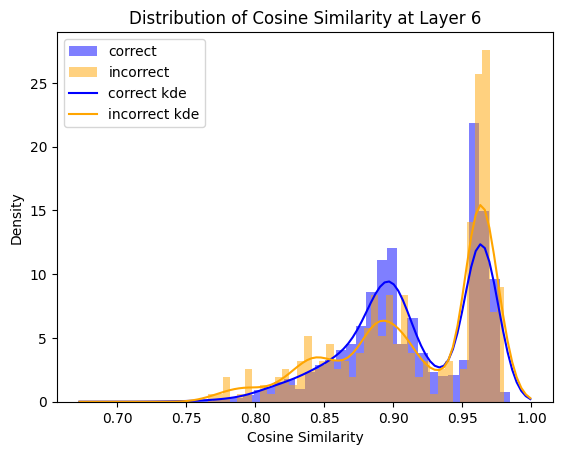

In [9]:
layer_num = stat_diff_layers[4]
plt.hist(train_correct[:, layer_num], bins=40, density=True, alpha=0.5, 
         label='correct', color='blue')
plt.hist(train_incorrect[:, layer_num], bins=40, density=True, alpha=0.5, 
         label='incorrect', color='orange')
# plt.vlines(x=correct_train_stats['median'][layer_num], ymin=0, ymax=plt.ylim()[1], color='blue', linestyle='--')
# plt.vlines(x=incorrect_train_stats['median'][layer_num], ymin=0, ymax=plt.ylim()[1], color='orange', linestyle='--')
x_eval = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
plt.plot(x_eval, np.exp(correct_kdes[layer_num].score_samples(x_eval[:, None])), 
         label='correct kde', color='blue')
plt.plot(x_eval, np.exp(incorrect_kdes[layer_num].score_samples(x_eval[:, None])), 
         label='incorrect kde', color='orange')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title(f'Distribution of Cosine Similarity at Layer {layer_num}')
plt.legend()
print(ks_2samp(train_correct[:, layer_num], train_incorrect[:, layer_num]).pvalue)

### Try different classification models

In [12]:
train_x = np.concatenate((train_correct[:, stat_diff_layers], train_incorrect[:, stat_diff_layers]), axis=0)
train_y = np.concatenate((np.zeros(train_correct.shape[0]), np.ones(train_incorrect.shape[0])), axis=0)
print(f'train_x.shape: {train_x.shape}')
print(f'train_y.shape: {train_y.shape}')
test_x = np.concatenate((test_correct[:, stat_diff_layers], test_incorrect[:, stat_diff_layers]), axis=0)
test_y = np.concatenate((np.zeros(test_correct.shape[0]), np.ones(test_incorrect.shape[0])), axis=0)
print(f'test_x.shape: {test_x.shape}')
print(f'test_y.shape: {test_y.shape}')

train_x.shape: (20002, 18)
train_y.shape: (20002,)
test_x.shape: (5001, 18)
test_y.shape: (5001,)


In [27]:
def apply_kdes(x, kdes):
  result = x.copy()
  for i, layer in enumerate(stat_diff_layers):
    result[:, i] = kdes[layer].score_samples(x[:, i][:, None])
  return result

train_x_kde_incorrect = apply_kdes(train_x, incorrect_kdes)
print(f'train_x_kde_incorrect.shape: {train_x_kde_incorrect.shape}')

train_x_kde_correct = apply_kdes(train_x, correct_kdes)
print(f'train_x_kde_correct.shape: {train_x_kde_correct.shape}')

train_x_kde = np.concatenate((train_x_kde_incorrect, train_x_kde_correct), axis=1)
print(f'train_x_kde.shape: {train_x_kde.shape}')

test_x_kde_incorrect = apply_kdes(test_x, incorrect_kdes)
print(f'test_x_kde_incorrect.shape: {test_x_kde_incorrect.shape}')

test_x_kde_correct = apply_kdes(test_x, correct_kdes)
print(f'test_x_kde_correct.shape: {test_x_kde_correct.shape}')

test_x_kde = np.concatenate((test_x_kde_incorrect, test_x_kde_correct), axis=1)
print(f'test_x_kde.shape: {test_x_kde.shape}')

train_x_kde_incorrect.shape: (20002, 18)
train_x_kde_correct.shape: (20002, 18)
train_x_kde.shape: (20002, 36)
test_x_kde_incorrect.shape: (5001, 18)
test_x_kde_correct.shape: (5001, 18)
test_x_kde.shape: (5001, 36)


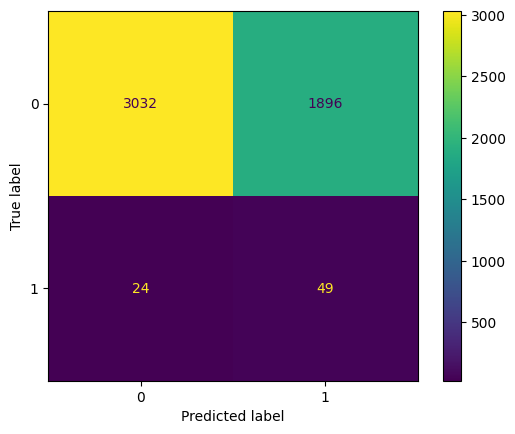

              precision    recall  f1-score   support

         0.0       0.99      0.62      0.76      4928
         1.0       0.03      0.67      0.05        73

    accuracy                           0.62      5001
   macro avg       0.51      0.64      0.40      5001
weighted avg       0.98      0.62      0.75      5001



In [ ]:
# frequentist approach
# compares how many layers have higher density for incorrect vs correct
# if more layers have higher density for incorrect, then the record is classified as incorrect

class_prob_incorrect = train_incorrect.shape[0] / (train_correct.shape[0] + train_incorrect.shape[0])
class_prob_correct = 1 - class_prob_incorrect
print(f'class_prob_incorrect: {class_prob_incorrect}')
print(f'class_prob_correct: {class_prob_correct}')

def frequentist_classifier(test_x, incorrect_kdes, correct_kdes, stat_diff_layers):
  predictions = []
  for i, layer in enumerate(stat_diff_layers):
    print(f'Processing layer {i+1} of {len(stat_diff_layers)}')
    incorrect_log_densities = incorrect_kdes[layer].score_samples(test_x[:, i][:, None])
    correct_log_densities = correct_kdes[layer].score_samples(test_x[:, i][:, None])
    layer_predictions = np.where(incorrect_log_densities > correct_log_densities, 1, 0)
    predictions.append(layer_predictions)
    clear_output(wait=True)
  predictions = np.array(predictions).T
  predictions = np.mean(predictions, axis=1)
  predictions = np.where(predictions > 0.5, 1, 0)
  return predictions

predictions = frequentist_classifier(test_x, incorrect_kdes, correct_kdes, stat_diff_layers)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))

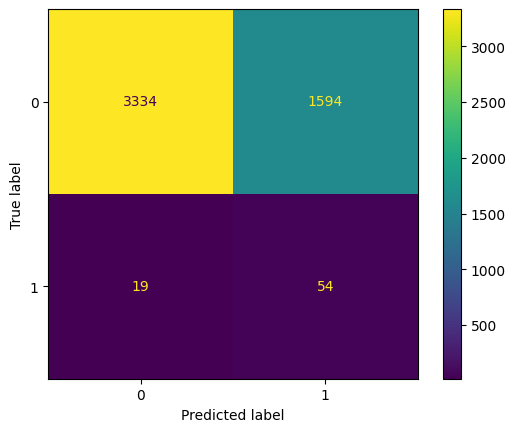

              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81      4928
         1.0       0.03      0.74      0.06        73

    accuracy                           0.68      5001
   macro avg       0.51      0.71      0.43      5001
weighted avg       0.98      0.68      0.79      5001



In [24]:
# different frequentist approach
# adds up the densities for each layer for incorrect and correct
# if incorrect has higher total density, then the record is classified as incorrect

def frequentist_classifier_2(test_x, incorrect_kdes, correct_kdes, stat_diff_layers):
  predictions = []
  for i, record in enumerate(test_x):
    if i % 100 == 0:
      print(f'Processing record {i+1} of {test_x.shape[0]}')
    incorrect_density = 0
    correct_density = 0
    for j, layer in enumerate(stat_diff_layers):
      incorrect_density += incorrect_kdes[layer].score(record[j].reshape(1, -1))
      correct_density += correct_kdes[layer].score(record[j].reshape(1, -1))
    if incorrect_density > correct_density:
      predictions.append(1)
    else:
      predictions.append(0)
    clear_output(wait=True)
  return np.array(predictions)

predictions = frequentist_classifier_2(test_x, incorrect_kdes, correct_kdes, stat_diff_layers)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))


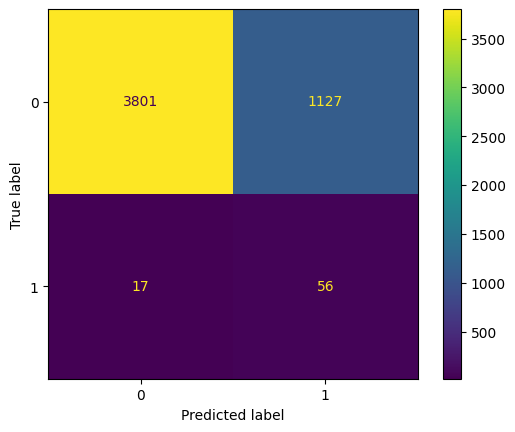

              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87      4928
         1.0       0.05      0.77      0.09        73

    accuracy                           0.77      5001
   macro avg       0.52      0.77      0.48      5001
weighted avg       0.98      0.77      0.86      5001



In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1, fit_intercept=True, 
                           class_weight='balanced')
model.fit(train_x, train_y)
conf_matrix = confusion_matrix(test_y, model.predict(test_x))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, model.predict(test_x)))

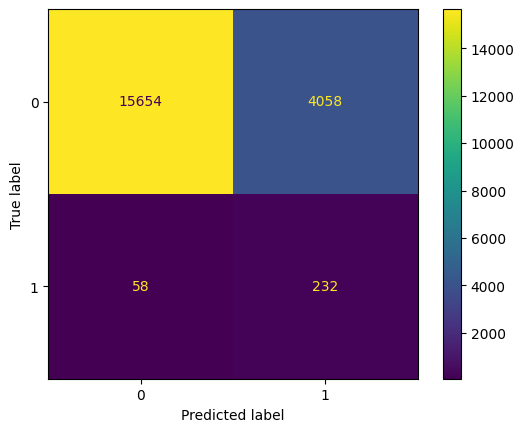

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88     19712
         1.0       0.05      0.80      0.10       290

    accuracy                           0.79     20002
   macro avg       0.53      0.80      0.49     20002
weighted avg       0.98      0.79      0.87     20002



In [28]:
model = LogisticRegression(n_jobs=-1, fit_intercept=True, penalty=None, solver='saga',
                           class_weight='balanced', max_iter=1000)
model.fit(train_x_kde, train_y)
# check if train data is overfit
conf_matrix = confusion_matrix(train_y, model.predict(train_x_kde))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(train_y, model.predict(train_x_kde)))

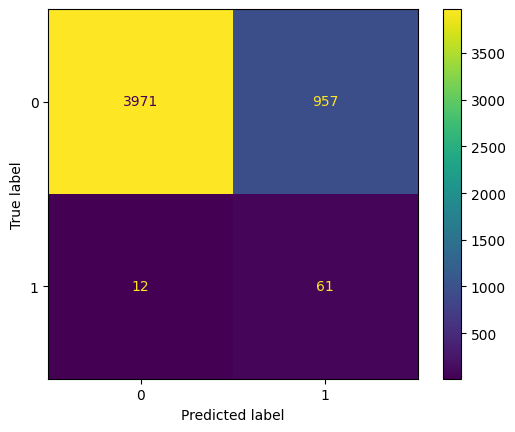

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89      4928
         1.0       0.06      0.84      0.11        73

    accuracy                           0.81      5001
   macro avg       0.53      0.82      0.50      5001
weighted avg       0.98      0.81      0.88      5001



In [29]:
# check performance on test data
conf_matrix = confusion_matrix(test_y, model.predict(test_x_kde))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, model.predict(test_x_kde)))

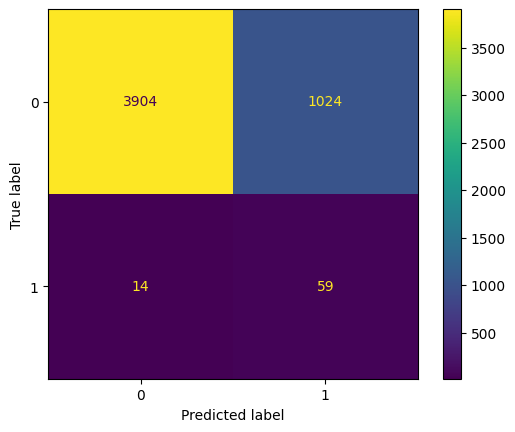

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88      4928
         1.0       0.05      0.81      0.10        73

    accuracy                           0.79      5001
   macro avg       0.53      0.80      0.49      5001
weighted avg       0.98      0.79      0.87      5001



In [30]:
# try mixture of expert models with balanced datasets
def train_logistic_regression(train_x, train_y):
    x_sample, y_sample = get_balanced_subsample(train_x, train_y)
    model = LogisticRegression(n_jobs=-1, fit_intercept=True, penalty=None, solver='saga',
                               max_iter=5000)
    model.fit(x_sample, y_sample)
    return model

predictions = []
num_models = 100
for i in range(num_models):
    print(f'Training model {i+1} of {num_models}')
    print(f'Training on {len(train_x)} samples')
    model = train_logistic_regression(train_x, train_y)
    predictions.append(model.predict(test_x))
    clear_output(wait=True)
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)
predictions = np.where(predictions > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))

In [35]:
# try svm
from sklearn.svm import SVC

for C in [0.01, 0.05, 0.1, 0.2, 0.5, 1.]:
    svc_model = SVC(class_weight='balanced', gamma='auto', C=C)
    svc_model.fit(train_x_kde, train_y)
    predictions = svc_model.predict(test_x_kde)
    metrics = classification_report(test_y, predictions, output_dict=True)
    print(f'C: {C}, recall: {metrics["1.0"]["recall"]}, precision: {metrics["1.0"]["precision"]}, f1: {metrics["1.0"]["f1-score"]}')


C: 0.01, recall: 0.7534246575342466, precision: 0.04741379310344827, f1: 0.08921330089213302
C: 0.05, recall: 0.7534246575342466, precision: 0.05248091603053435, f1: 0.09812667261373774
C: 0.1, recall: 0.7945205479452054, precision: 0.05415499533146592, f1: 0.10139860139860139
C: 0.2, recall: 0.7808219178082192, precision: 0.0561576354679803, f1: 0.10477941176470588
C: 0.5, recall: 0.7808219178082192, precision: 0.06298342541436464, f1: 0.1165644171779141
C: 1.0, recall: 0.7671232876712328, precision: 0.0673076923076923, f1: 0.12375690607734807


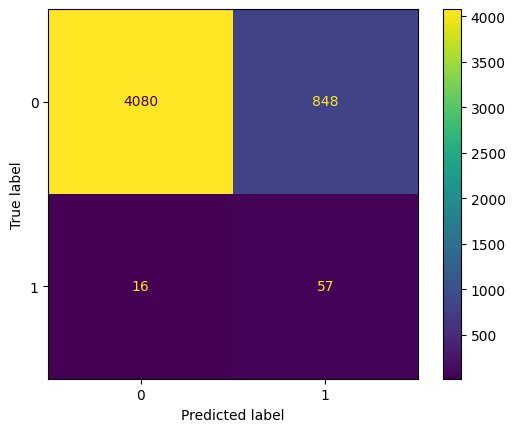

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.90      4928
         1.0       0.06      0.78      0.12        73

    accuracy                           0.83      5001
   macro avg       0.53      0.80      0.51      5001
weighted avg       0.98      0.83      0.89      5001



In [48]:
svc_model = SVC(class_weight='balanced', gamma='auto', C=0.5)
svc_model.fit(train_x_kde, train_y)
predictions = svc_model.predict(test_x_kde)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))

In [57]:
# try mixture of expert models with balanced datasets
def train_svc(train_x, train_y, C):
    x_sample, y_sample = get_balanced_subsample(train_x, train_y)
    model = SVC(gamma='auto', C=C)
    model.fit(x_sample, y_sample)
    return model
num_models = 100
for C in [10, 30, 70, 100, 300, 700]:
    predictions = []
    print(f'Training models with C={C}')
    for i in range(num_models):
        model = train_svc(train_x_kde, train_y, C=C)
        predictions.append(model.predict(test_x_kde))
    predictions = np.array(predictions)
    predictions = np.mean(predictions, axis=0)
    predictions = np.where(predictions > 0.5, 1, 0)
    metrics = classification_report(test_y, predictions, output_dict=True)
    print(f'recall: {metrics["1.0"]["recall"]}, precision: {metrics["1.0"]["precision"]}, f1: {metrics["1.0"]["f1-score"]}')

Training models with C=10
recall: 0.8082191780821918, precision: 0.05888223552894212, f1: 0.10976744186046512
Training models with C=30
recall: 0.8082191780821918, precision: 0.06512141280353201, f1: 0.1205311542390194
Training models with C=70
recall: 0.7945205479452054, precision: 0.06666666666666667, f1: 0.12301166489925769
Training models with C=100
recall: 0.7808219178082192, precision: 0.06674473067915691, f1: 0.12297734627831715
Training models with C=300
recall: 0.726027397260274, precision: 0.06575682382133995, f1: 0.12059158134243458
Training models with C=700
recall: 0.7397260273972602, precision: 0.06985769728331177, f1: 0.1276595744680851


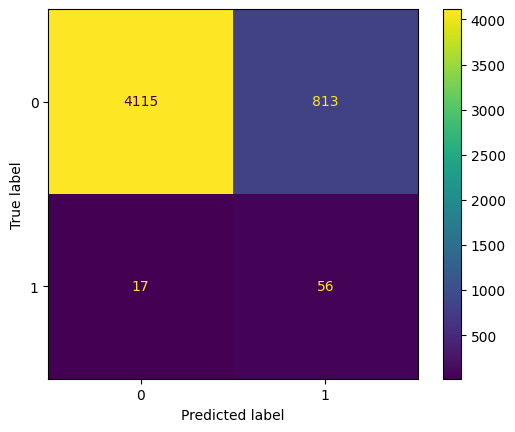

              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      4928
         1.0       0.06      0.77      0.12        73

    accuracy                           0.83      5001
   macro avg       0.53      0.80      0.51      5001
weighted avg       0.98      0.83      0.90      5001



In [60]:
predictions = []
for i in range(num_models):
    model = train_svc(train_x_kde, train_y, C=40)
    predictions.append(model.predict(test_x_kde))
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)
predictions = np.where(predictions > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))

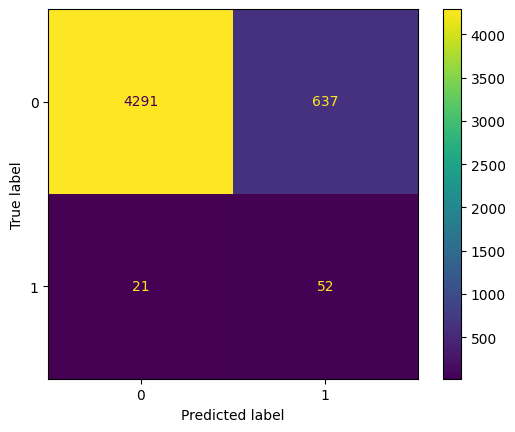

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      4928
         1.0       0.08      0.71      0.14        73

    accuracy                           0.87      5001
   macro avg       0.54      0.79      0.53      5001
weighted avg       0.98      0.87      0.92      5001



In [63]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(train_x, train_y):
    x_sample, y_sample = get_balanced_subsample(train_x, train_y)
    model = RandomForestClassifier(n_estimators=1000, random_state=42, 
                                   n_jobs=-1, max_features=None, bootstrap=False)
    model.fit(x_sample, y_sample)
    return model

predictions = []
num_models = 200
for i in range(num_models):
    print(f'Training model {i+1} of {num_models}')
    model = train_random_forest(train_x_kde, train_y)
    predictions.append(model.predict(test_x_kde))
    clear_output(wait=True)
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)
predictions = np.where(predictions > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))

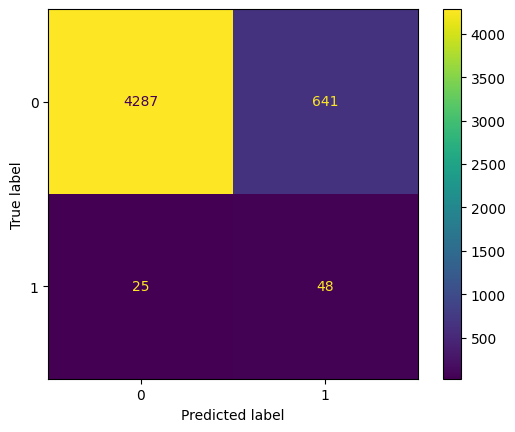

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      4928
         1.0       0.07      0.66      0.13        73

    accuracy                           0.87      5001
   macro avg       0.53      0.76      0.53      5001
weighted avg       0.98      0.87      0.92      5001



In [83]:
from sklearn.ensemble import HistGradientBoostingClassifier

# reg = 100
# lr = 0.1
# for reg in [0.1, 10, 100, 1000, 10000]:  
#     print(f'Training model with reg={reg}, lr={lr}')
#     model = HistGradientBoostingClassifier(random_state=42, class_weight='balanced', 
#                                         learning_rate=lr, l2_regularization=reg, 
#                                         max_iter=1000, max_leaf_nodes=None)
#     model.fit(train_x_kde, train_y)
#     predictions = model.predict(test_x_kde)
#     metrics = classification_report(test_y, predictions, output_dict=True)
#     print(f'recall: {metrics["1.0"]["recall"]}, precision: {metrics["1.0"]["precision"]}, f1: {metrics["1.0"]["f1-score"]}')

model = HistGradientBoostingClassifier(random_state=42, class_weight='balanced', 
                                       learning_rate=0.5, l2_regularization=10000,
                                       max_iter=1000, max_leaf_nodes=None)
model.fit(train_x_kde, train_y)
predictions = model.predict(test_x_kde)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))


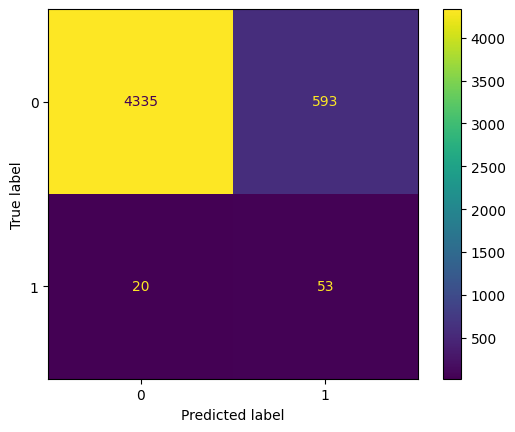

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93      4928
         1.0       0.08      0.73      0.15        73

    accuracy                           0.88      5001
   macro avg       0.54      0.80      0.54      5001
weighted avg       0.98      0.88      0.92      5001



In [84]:
from sklearn.ensemble import GradientBoostingClassifier

def train_gradient_boosting(train_x, train_y):
    sample_x, sample_y = get_balanced_subsample(train_x, train_y)
    model = GradientBoostingClassifier(random_state=42, learning_rate=0.2, 
                                        n_estimators=1000, max_depth=10, subsample=1.)
    model.fit(sample_x, sample_y)
    return model


predictions = []
num_models = 100
for i in range(num_models):
    print(f'Training model {i+1} of {num_models}')
    model = train_gradient_boosting(train_x, train_y)
    predictions.append(model.predict(test_x))
    clear_output(wait=True)
predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)
predictions = np.where(predictions > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_y, predictions)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()
print(classification_report(test_y, predictions))